In [97]:
# импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [98]:
# грузим данные
file_name = 'C:/Users/Uldum/Downloads/prostate.csv'
my_data = pd.read_csv(file_name, sep='\t', index_col=0)

In [99]:
# смотрим на данные, ничего не понимаем. Вроде наша целевая переменная - lpsa. а столбец train разбивает данные на
# тренировочные и тестовые. Отлично. Идём дальше
my_data

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...
93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


In [100]:
# чекаем незаполненные ячейки (их нет)
my_data.isna().sum()

lcavol     0
lweight    0
age        0
lbph       0
svi        0
lcp        0
gleason    0
pgg45      0
lpsa       0
train      0
dtype: int64

Text(0.5, 1.0, 'Missing value in the dataset')

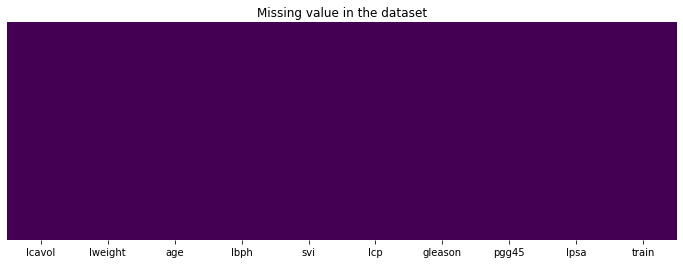

In [101]:
# рисуем тепловую карту незаполненных значений (их нет)
plt.figure(figsize=(12,4))
sns.heatmap(my_data.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset')

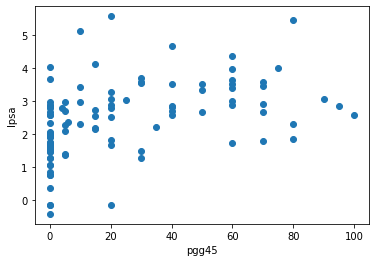

In [102]:
# рисуем показатель Глисона (pgg45) от логарифма уровня простатспецифического антигена (lpsa)
def scatter(my_data, x_name):
    plt.scatter(my_data[x_name], my_data['lpsa'])
    plt.xlabel(x_name)
    plt.ylabel('lpsa')
    plt.show()

scatter(my_data, 'pgg45')

<AxesSubplot:>

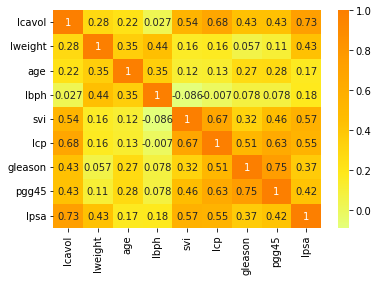

In [103]:
# рисуем тепловую карту корреляций независимых переменных (признаков) друг от друга, сохраняя метод corr в переменной
# в общем случае коррелирующие друг с другом зависимые переменные для линейной регрессии нам не нужны, 
# так как возникают проблемы с механикой работы алгоритма (поиском обратной матрицы)
corr = my_data.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True)

Text(0.5, 1.0, 'Distribution of lpsa')

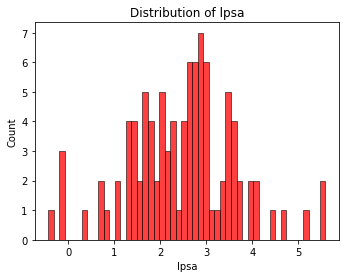

In [104]:
# рисуем распределение lpsa и смотрим похоже ли оно на нормальное (хотелось бы)
# в нашем случае похоже, но если нет, то существуют способы модификации данных с помощью логарифмирования, например
f= plt.figure(figsize=(12,4))
ax=f.add_subplot(121)
sns.histplot(my_data['lpsa'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of lpsa')

Text(0.5, 1.0, 'Scatter plot of lpsa vs age')

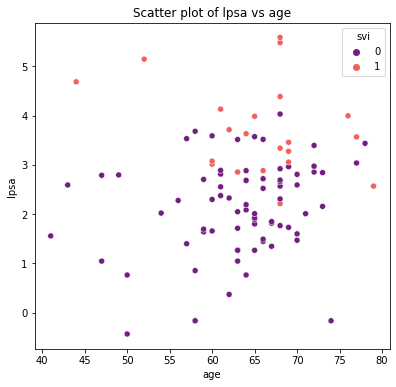

In [105]:
# скаттер зависимости lpsa от age для svi 0 и 1. Ничего полезного, но раз уж начал строить графики, то тяжело остановиться
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='lpsa',data=my_data,palette='magma',hue='svi',ax=ax)
ax.set_title('Scatter plot of lpsa vs age')

In [106]:
# с визулизацией данных мы зкончили. Распределение нас устраивает, незаполненных данных нет, нормализация
# встроена в методы sklearn, пройдёт автоматически, все данные числовые. 
# Можно ещё посмотреть выбросы показателей.

# так как распределение +- близко к нормальному, то воспольуемся методом квартилей. Находим занчения 1 и 3 квартилей
Q1 = np.percentile(my_data['lpsa'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(my_data['lpsa'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", my_data.shape)

# дропаем строки, в которых значения 'lpsa' выходят влево или вправо за рамки 1 и 3 квартилей. 
my_data.drop(my_data.index[my_data['lpsa'] >= (Q3+1.5*IQR)], inplace = True)
my_data.drop(my_data.index[my_data['lpsa'] <= (Q1-1.5*IQR)], inplace = True)

print("New Shape: ", my_data.shape)
# принтуем размер датафрейма, чтобы убедиться, что что-то таки удалилось. На ворнинги не обращаем внимания - это для слабаков

Old Shape:  (97, 10)
New Shape:  (93, 10)


C:\Users\Uldum\AppData\Local\Temp\ipykernel_10424\2687711280.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(my_data['lpsa'], 25,
C:\Users\Uldum\AppData\Local\Temp\ipykernel_10424\2687711280.py:9: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(my_data['lpsa'], 75,


In [107]:
# ещё мне не нравится колонка 'svi', которая принимает значения 0 или 1. Похожа на категориальную.
# применим к ней метод .dummies, который, если верить зарубежным коллегам, также страхует нас от излишней корреляции
# признаков друг с другом и строковых данных
# засунем туда строки 'svi' - подозреваемую в категориальности, 'train' - строковая, да ещё и категориальная (да, она вооб-
# ще не будет использоваться в модели обучения, просто хочу посмотреть что метод с ней сделает), а также строку 'gleason' - 
# судя по тепловой карте корреляций этот признак сильно коррелирует с 'pgg', и у него меньше корреляция с целевой переменной,
# так что посомтрим что будет.
categorical_columns = ['svi','train', 'gleason']
df_encode = pd.get_dummies(data = my_data, prefix = 'ENC', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
              dtype='int8')

In [108]:
df_encode
# поглядим. Понятно. Столбец 'train' разделился на два и они заполнились 1 и 0 в зависимости от буквы.
# 'svi' вообще не поменялся, как были 1 и 0, так и остались.

,lcavol,lweight,age,lbph,lcp,pgg45,lpsa,ENC_1,ENC_T,ENC_7,ENC_8,ENC_9
2,-0.994252,3.319626,58,-1.386294,-1.386294,0,-0.162519,0,1,0,0,0
3,-0.510826,2.691243,74,-1.386294,-1.386294,20,-0.162519,0,1,1,0,0
4,-1.203973,3.282789,58,-1.386294,-1.386294,0,-0.162519,0,1,0,0,0
5,0.751416,3.432373,62,-1.386294,-1.386294,0,0.371564,0,1,0,0,0
6,-1.049822,3.228826,50,-1.386294,-1.386294,0,0.765468,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
90,1.562346,3.695110,76,0.936093,0.810930,75,3.993603,1,1,1,0,0
91,3.246491,4.101817,68,-1.386294,-1.386294,0,4.029806,0,1,0,0,0
92,2.532903,3.677566,61,1.348073,-1.386294,15,4.129551,1,1,1,0,0
93,2.830268,3.876396,68,-1.386294,1.321756,60,4.385147,1,1,1,0,0


<AxesSubplot:>

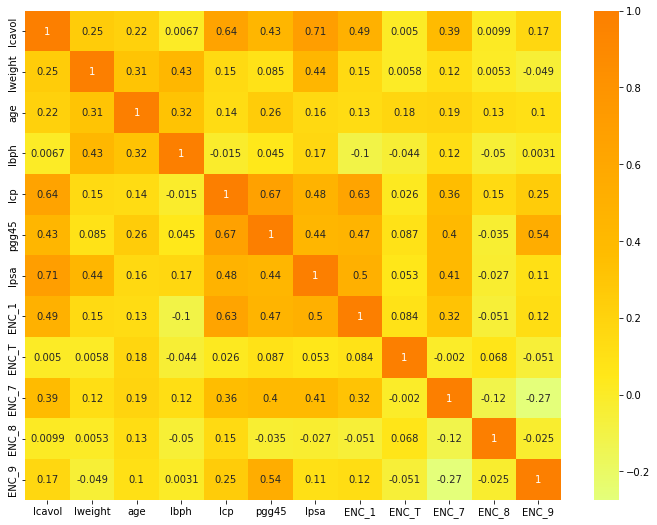

In [109]:
# попробуем построить тепловую карту корреляции опять и посмотреть.
plt.figure(figsize=(12, 9))
corr = df_encode.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True)

In [110]:
# вроде корреляций выше 0.7 не наблюдается, поэтому откатим метод .dummy и применим его только к признаку 'gleason'
# может ничего плохого не случится, а может случится. И сразу дропнем бесполезный столбец 'train'
categorical_columns = ['gleason']
df_encode = pd.get_dummies(data = my_data, prefix = 'ENC', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
              dtype='int8')
fin_data = df_encode.drop('train', axis = 1)
fin_data

,lcavol,lweight,age,lbph,svi,lcp,pgg45,lpsa,ENC_7,ENC_8,ENC_9
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,0,-0.162519,0,0,0
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,20,-0.162519,1,0,0
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,0,-0.162519,0,0,0
5,0.751416,3.432373,62,-1.386294,0,-1.386294,0,0.371564,0,0,0
6,-1.049822,3.228826,50,-1.386294,0,-1.386294,0,0.765468,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
90,1.562346,3.695110,76,0.936093,1,0.810930,75,3.993603,1,0,0
91,3.246491,4.101817,68,-1.386294,0,-1.386294,0,4.029806,0,0,0
92,2.532903,3.677566,61,1.348073,1,-1.386294,15,4.129551,1,0,0
93,2.830268,3.876396,68,-1.386294,1,1.321756,60,4.385147,1,0,0


In [111]:
# давайте уже обучим модель. По идее, данные нужно делить на тестовые и тренировочные, сделаем это
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [112]:
# сплитим данные на признаки и целевую переменную (lpsa)
X = fin_data.drop(['lpsa'], axis = 1)  # данные без целевой переменной
y = fin_data.lpsa          # данные с целевой переменной (ответы)
X                          # выводим посмотреть что там, на всякий случай

,lcavol,lweight,age,lbph,svi,lcp,pgg45,ENC_7,ENC_8,ENC_9
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,0,0,0,0
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,20,1,0,0
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,0,0,0,0
5,0.751416,3.432373,62,-1.386294,0,-1.386294,0,0,0,0
6,-1.049822,3.228826,50,-1.386294,0,-1.386294,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
90,1.562346,3.695110,76,0.936093,1,0.810930,75,1,0,0
91,3.246491,4.101817,68,-1.386294,0,-1.386294,0,0,0,0
92,2.532903,3.677566,61,1.348073,1,-1.386294,15,1,0,0
93,2.830268,3.876396,68,-1.386294,1,1.321756,60,1,0,0


In [113]:
# сплитим данные на тренировочные и тестовые методом .train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0, test_size = 0.25)

In [114]:
# создадим экземпляр класса линейнй регрессии и пойдём читать мануал по параметрам
# fit_intercept оставим по усолчанию True - значение b0 в регрессии
# normalize = Ttue, а вот это деду надо, запишем
# copy_X - пусть будет по умолчанию, почему бы нет
# n_jobs = -1 выставим -1 (задействует все процессоры) и запшем
# с параметрами самого эстиматора (оценщика) всё
lin_reg = LinearRegression(normalize = True, n_jobs = -1)
# попробуем обучить так
lin_reg.fit(X_train, y_train)

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(n_jobs=-1, normalize=True)

In [115]:
# предсказываем по обученной модели 'y' на X_test данных, выводим показатель квадрата среднего квадр. отклонения (меньше - лучше)
predicted = lin_reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, predicted))

0.6374981934622934

In [117]:
# показатель точности результатов алгоритма (больше-лучше)
lin_reg.score(X_test,y_test)

0.60122222530211

In [119]:
# показания не ахти, пробуем без преобразования данных, они и так скачаны откуда надо
# возможно, всеми этими танцами с думми мы делаем только хуже
# проделываем все заново с чистыми данными, выводим квадрат
file_name = 'C:/Users/Uldum/Downloads/prostate.csv'
my_data = pd.read_csv(file_name, sep='\t', index_col=0)
X = my_data.drop(['lpsa', 'train'], axis = 1)  # данные без целевой переменной
y = my_data.lpsa          # данные с целевой переменной (ответы)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 4, test_size = 0.25)       
lin_reg_def = LinearRegression(normalize = True, n_jobs = -1)
lin_reg_def.fit(X_train, y_train)
predicted_def = lin_reg_def.predict(X_test)
np.sqrt(mean_squared_error(y_test, predicted_def))

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


0.5228004625407247

In [120]:
# выводим коэффициенты при переменных - они же вес фич (признаков)
lin_reg_def.coef_

array([ 0.58829069,  0.72821673, -0.02156998,  0.06779439,  0.86145685,
       -0.13547508,  0.07645877,  0.00358475])

In [121]:
# выводим b0
lin_reg_def.intercept_

-0.35148943604336313

In [122]:
# выводим точность
lin_reg_def.score(X_test,y_test)

0.7653313733560395

In [ ]:
И того: модифицированные данные:
        Квадрат отклонения: 0.63749
        Точность: 0.60122
Квадрат больше точности - это надо постараться.
        немодифицированные данные:
        Квадрат отклонения: 0.5228
        Точность: 0.76533
Потянет, но попробуем что-то ещё.

In [125]:
# проделываем всё заново, но теперь, на основании выведенных выше коэффициентов при переменных (весов), оставим
# только те столбцы, в которых корреляция модели была максимальной
# выведем квадрат
file_name = 'C:/Users/Uldum/Downloads/prostate.csv'
my_data = pd.read_csv(file_name, sep='\t', index_col=0)
X = my_data[['svi', 'lcavol', 'lcp']]  # данные без целевой переменной
y = my_data.lpsa          # данные с целевой переменной (ответы)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 4, test_size = 0.25)       
lin_reg_def1 = LinearRegression(normalize = True, n_jobs = -1)
lin_reg_def1.fit(X_train, y_train)
predicted_def = lin_reg_def1.predict(X_test)
np.sqrt(mean_squared_error(y_test, predicted_def))

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


0.6232201187519223

In [126]:
# выведем точность
lin_reg_def1.score(X_test,y_test)

0.6665228855427933

In [ ]:
Для отобранных переменных ситуация получилась чуть лучше, чем в первый раз, но хуже, чем со всеми переменными и чистыми данными:
    Квадрат: 0.62322
    Точность: 0.6665

Что же, идём дальше. Комбинация методик (методов).

In [127]:
# пробнем Ридж-регрессию + Грид-сёрч кросс-валидацию, чтобы улучшить показатели
# подгружаем необходимые моудли, перекачиваем чистые данные заново, сплитим на X - без целевой переменной и без 'train' и y - цп
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
file_name = 'C:/Users/Uldum/Downloads/prostate.csv'
my_data = pd.read_csv(file_name, sep='\t', index_col=0)
X = my_data.drop(['lpsa', 'train'], axis = 1)  # данные без целевой переменной
y = my_data.lpsa          # данные с целевой переменной (ответы)
# сплитим на выборку тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 4, test_size = 0.25)
# задаём диапазоны параметров, которые относятся к эстиматору Ридж, но пойдут в параметры поисковой сетки GridSearch
# задан диапазон параметров с шагом, чтобы быстрее обучалось (можно точнее), но и без того получится 720 комбинаций, а у меня i3 - )
# по параметрам читаем документацию для Ридж-регрессии
parameters = {'alpha':[0.1, 10, 0.5], 'normalize': [True, False], 'max_iter': [100, 10000, 500], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']} 
# задаём модель Ридж
model = Ridge()
# закидываем в сетку Грид наш эстиматор, его параметры, сравнительный показатель (scoring), задаём число фолдов для кросс-валидации
# по поводу scoring. Сначала я пытался сравнивать по mean_squared_error (без neg_), но потом понял, что бедная поисковая
# сетка не понимает как сравнивать один показатель с другим (какой лучше, какой хуже), поэтому надо добавить neg_ - ниже - лучше
# и на основании этоо показателя уже выстраивать иерархию эстиматоров, которые сетка наобучала
Ridge_reg= GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=5)
# фитим выборки в ридж, забиваем на ворнинги
Ridge_reg.fit(X_train, y_train)

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as fol

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preproce

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Uldum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:1

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 10, 0.5], 'max_iter': [100, 10000, 500],
                         'normalize': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']},
             scoring='neg_mean_squared_error')

In [128]:
# выводим лучший подобранный сеткой эстиматор с лучшими параметрами по показателю скоринга (квадрата отклонений)
Ridge_reg.best_estimator_

Ridge(alpha=0.1, max_iter=500, normalize=True, solver='saga')

In [129]:
# выводим точность лучшего эстиматора, используя тестовые отложенные выборки
Ridge_reg.best_estimator_.score(X_test,y_test)

0.7813306902265982

In [130]:
# теперь выводим квадрат отклонений
pred_rid = Ridge_reg.best_estimator_.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred_rid))

0.5046640449972374

In [ ]:
Итак,
Ridge+GridSearchCV дали лучший результат:
    Квадрат: 0.7813
    Точность: 0.5046
Всё остальное далеко позади, что даже смысла нет искать и добавлять те данные в какую-то сводную таблицу.
Вывод: лучше брутфорсить параметры с GridSearchCV и продвинутыми алгоритмами, параметры которых можно тюнить,
    чем вручную пытаться обучать классические алгоритмы
    
Вывод2: некоторые данные лучше не модифицировать - )